In [1]:
# !pip install langchain-opentutorial

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("CH15-Agentic-RAG")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agentic-RAG


# NaiveRAG + RelevanceCheck + WebSearch

** 실습 자료 **

소프트웨어정책연구소(SPRi), [AI Brief 스페셜] AI 에이전트 동향

- 저자: 유재흥(AI정책연구실 책임연구원), 이해수(AI정책연구실 선임연구원)
- 발생: 2024.12.10
- 링크: https://spri.kr/posts/view/23798?code=AI-Brief&s_year=&data_page=1
- 파일명: `SPRi AI Brief_Special_AI Agent_241209_F`

(실습 준비)
- 작업 폴더 하위에 `data` 폴더 생성 
- 링크에서 다운로드 받은 파일을 `data` 폴더에 업로드 

In [3]:
file_path = ["data/SPRi AI Brief_Special_AI Agent_241209_F.pdf"]

### Retrieval Chain

In [4]:
from langchain_opentutorial.rag.pdf import PDFRetrievalChain

In [5]:
pdf_file = PDFRetrievalChain(file_path).create_chain()

pdf_retriever = pdf_file.retriever
pdf_chain = pdf_file.chain

### State 정의

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

In [7]:
class GraphState(TypedDict):  
    question: Annotated[str, "Question"]    # 질문  
    context: Annotated[str, "Context"]      # 문서의 검색 결과  
    answer: Annotated[str, "Answer"]        # 답변  
    messages: Annotated[list, add_messages] # 메시지(누적되는 list)  
    relevance: Annotated[str, "Relevance"]  # 관련성  

### Node 정의

In [8]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from langchain_opentutorial.rag.utils import format_docs

이미 정의한 노드

In [9]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs) # 검색된 문서를 형식화(프롬프트 입력으로 넣어주기 위함)
    # 검색된 문서를 context 키에 저장
    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]

    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장
    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )

In [10]:
# 관련성 체크 노드  
def relevance_check(state: GraphState) -> GraphState:  
    # 관련성 평가기 생성
    question_answer_relevant = GroundednessChecker(  
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"  
    ).create()  

    # 관련성 체크를 실행("yes" or "no")  
    response = question_answer_relevant.invoke(  
        {"question": state["question"], "context": state["context"]}  
    )  

    print("==== [RELEVANCE CHECK] ====")  
    print(response.score)  
    return GraphState(relevance=response.score)  


# 관련성 체크하는 함수(router)  
def is_relevant(state: GraphState) -> GraphState:  
    return state["relevance"]  

검색 노드 (신규 정의)

In [11]:
from langchain_teddynote.tools.tavily import TavilySearch

In [12]:
# 검색 도구 생성
tavily_tool = TavilySearch()

search_query = "Apple Intelligence의 시장 반응은?"

# 다양한 파라미터를 사용한 검색 예제
search_result = tavily_tool.search(
    query=search_query,  # 검색 쿼리
    topic="news",        # 검색 주제
    days=1,              # 최근 1일 내 검색
    max_results=3,       # 최대 검색 결과
    format_output=True,  # 결과 포맷팅
)

print("\n".join(search_result))

<document><title>Samsung sidelined Galaxy S21, S22 and S23 flagships, Galaxy M56 makes it crystal clear - Sammy Fans</title><url>https://www.sammyfans.com/2025/04/19/samsung-sidelined-galaxy-s21-and-s22-flagships-galaxy-m56-makes-it-crystal-clear/</url><content>Breaking: Samsung Galaxy S25 gets April 2025 update with new One UI 7 features Samsung Galaxy S23 may get Android 15 (One UI 7) update next week Besides a new camera design and sleek profile, the new Samsung Galaxy M56 brings One UI 7 out of the box and supports six years of Android and security updates. Samsung will bring Android 16 to Galaxy devices as part of One UI 8. *   One UI3 days ago April 22 release for Galaxy S23 One UI 7 (Android 15) update now off the table *   One UI2 days ago BREAKING: Samsung resumes One UI 7 rollout, Galaxy S24 gets new BYD9 update *   One UI2 days ago Samsung has an advisory for One UI 7 eligible device owners *   Samsung2 days ago Reminder: Samsung Galaxy S21 series will get One UI 7 (Android 

In [13]:
# Web Search 노드
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()
    search_query = state["question"]
    search_result = tavily_tool.search(
        query=search_query,  # 검색 쿼리
        topic="news",        # 일반 주제
        days=1,
        max_results=3,       # 최대 검색 결과
        format_output=True,  # 결과 포맷팅
    )

    return GraphState(context="\n".join(search_result))

### 그래프 정의

In [14]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [15]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

workflow.add_edge("retrieve", "relevance_check") 

workflow.add_conditional_edges(
    "relevance_check",  
    is_relevant,
    {
        "yes": "llm_answer", 
        "no": "web_search",  
    },
)

workflow.add_edge("web_search", "llm_answer")  
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("retrieve")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

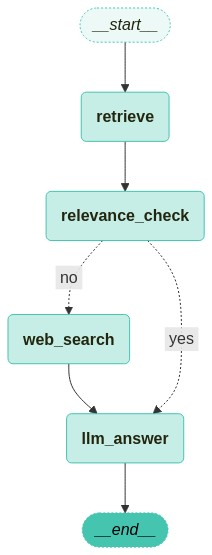

In [16]:
from langchain_teddynote.graphs import visualize_graph  

visualize_graph(app)  

### 그래프 실행

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

In [18]:
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})
inputs = GraphState(question="도널드 트럼프 대통령")

stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
no

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
도널드 트럼프 대통령은 미국의 45대 대통령으로, 일본에 미국 자동차 수입을 늘리도록 압박하고 있으며, 자동차 안전 규정을 완화하는 방안을 협상 테이블에 올리고 있습니다. 그는 또한 "해방의 날"이라는 세금 발표로 인해 달러 가치가 하락하는 등 경제 정책에 대한 신뢰를 약화시키고 있습니다.

**Source**
- Japan to put car safety standards on table in Trump tariffs talks - Nikkei Asia
- Is the US dollar at risk of a ‘confidence crisis’? - Al Jazeera

In [19]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 도널드 트럼프 대통령
Answer:
도널드 트럼프 대통령은 미국의 45대 대통령으로, 일본에 미국 자동차 수입을 늘리도록 압박하고 있으며, 자동차 안전 규정을 완화하는 방안을 협상 테이블에 올리고 있습니다. 그는 또한 "해방의 날"이라는 세금 발표로 인해 달러 가치가 하락하는 등 경제 정책에 대한 신뢰를 약화시키고 있습니다.

**Source**
- Japan to put car safety standards on table in Trump tariffs talks - Nikkei Asia
- Is the US dollar at risk of a ‘confidence crisis’? - Al Jazeera


-----
** End of Documents **